In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt

BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
all_batches = []
all_labels =[]
torch.manual_seed(10)
for x,y in test_dataloader:
    bs = x.shape[0]
    all_batches.append(x.flatten().reshape(bs,784))
    all_labels.append(y)

all_batches = torch.cat(all_batches,dim=0)
all_labels = torch.cat(all_labels,dim=0)



data_c1 = all_batches[all_labels==0].detach().numpy()
data_c2 = all_batches[all_labels==7].detach().numpy()
data_c3 = all_batches[all_labels==1].detach().numpy()


#DATA = np.vstack((data_c1[:100,:],data_c2[400:600,:],data_c1[100:700,:]))
DATA = np.vstack((data_c1,data_c2,data_c3))

len(DATA)

3143

In [51]:
data_c1.shape

(980, 784)

In [19]:
import pandas as pd

#pd.DataFrame(DATA).to_csv('DATA.csv')

np.save('MNIST_dummy.npy',DATA)

In [54]:
from tqdm import tqdm
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)
LENGHT = 100
SPLIT = 0.5
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,LENGHT,split=SPLIT))
SWDs = []

calibrated = False
t = 0
skip_count = 0  # To track the number of skipped iterations
segmentation ={}
segments=0
t0=int(LENGHT*SPLIT)-1
loss_segments = []
begin = time.time()
#loss_segments = []
THETA = sample_theta_torch(DATA, 5000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    # Skip iterations if `skip_count` is active
    if skip_count > 0:
        skip_count -= 1
        #print("skipped {}".format(i))
        continue

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    #THETA = sample_theta_torch(x_ref, 1000)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss.mean())
    SWDs.append(loss.mean())
    #print("t={} with {}".format(i+LENGHT,mom_estimates(list(loss_segments))))
    # Calibration phase
    if not calibrated:
        alpha_hat, beta_hat = mom_estimates(loss)
        alpha_CI, beta_CI = estimate_parameter_CI(loss,0.99)
        calibrated = True
        lower_CI = [0]
        upper_CI = [0]
        cumsum = loss.mean()
        t = 0  # Start t at 1 since we already processed one loss
        #loss_segments.append(loss)
        skip_ci = True

    # Monitoring phase
    if calibrated:
        if skip_ci:
            t=+1
            skip_ci = False
            continue
        else:
            t += 1
            #l, u = gamma_conf_interval(t, alpha_hat, 1 / beta_hat, 0.99)
            l1, u1 = gamma_conf_interval(t, alpha_CI[0], 1 / beta_CI[0], 0.99)
            l2, u2 = gamma_conf_interval(t, alpha_CI[1], 1 / beta_CI[1], 0.99)
            l = min(l1,l2)
            u = max(u1,u2)
            lower_CI.append(l)
            upper_CI.append(u)
            cumsum += loss.mean()
        




        # Check if a change point is detected
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at iteration {i + int(LENGHT*SPLIT)}")
            #print(mom_estimates(loss))
            #print(mom_estimates(np.hstack(loss_segments)))
            segmentation[segments] = {'t0':t0,'t1':i+(LENGHT*SPLIT),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs,'a_hat':alpha_CI,'b_hat':beta_CI}
            calibrated = False  # Reset calibration
            cumsum = 0
            t = 0
            skip_count = LENGHT #int(LENGHT*SPLIT)  # Skip the next 15 iterations
            SWDs = []
            segments+=1
            t0=i+LENGHT
            #loss_segments = []
            #THETA = sample_theta_torch(x_ref, 500)
        #loss_segments.append(loss)
    #t+=1
segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*SPLIT),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
end = time.time()
print(end-begin)

cuda


 34%|███▍      | 1032/3044 [00:04<00:04, 488.66it/s]

Change Alarm at iteration 968


 61%|██████    | 1847/3044 [00:08<00:02, 492.60it/s]

Change Alarm at iteration 1781


 68%|██████▊   | 2055/3044 [00:08<00:01, 512.92it/s]

Change Alarm at iteration 1992


 73%|███████▎  | 2208/3044 [00:08<00:01, 570.24it/s]

Change Alarm at iteration 2138


 80%|████████  | 2440/3044 [00:09<00:01, 500.33it/s]

Change Alarm at iteration 2371


 85%|████████▌ | 2601/3044 [00:09<00:00, 483.42it/s]

Change Alarm at iteration 2569


100%|██████████| 3044/3044 [00:11<00:00, 259.03it/s]

11.799327850341797


In [38]:
def plot_statistic(ax,data,ax2):
    c = 0
    for key in data:
        segment = data[key]
        if c == 0:
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0,label='SWD')
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5,label='Test statstic')
        else: 
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0)
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['lower'],color='blue',lw=1,alpha=0.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],color='blue',lw=1,alpha=0.5)
        ax.fill_between(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],segment['lower'],color='blue',alpha=0.2)
        c+=1

    return ax

ValueError: x and y must have same first dimension, but have shapes (763,) and (713,)

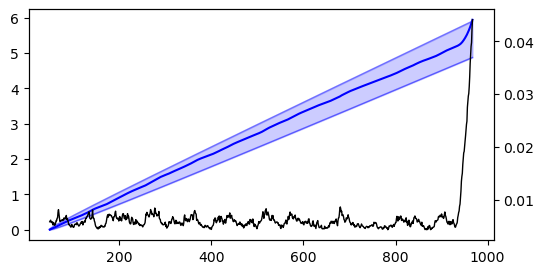

In [55]:
fig, ax = plt.subplots(figsize=(6,3))
ax2 = ax.twinx()
plot_statistic(ax,segmentation,ax2)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')
fig.tight_layout()


In [57]:
segmentation[1]

{'t0': 1018,
 't1': 1781.0,
 'statistic': array([0.00576999, 0.01106673, 0.01632359, 0.02182852, 0.02778215,
        0.03429145, 0.04057098, 0.04639599, 0.05233175, 0.05817118,
        0.06402391, 0.06976712, 0.07529956, 0.08061387, 0.08615295,
        0.09176517, 0.09767523, 0.10300015, 0.10828031, 0.11324354,
        0.11859308, 0.12423277, 0.12942949, 0.13461055, 0.13985673,
        0.1443257 , 0.14900441, 0.15389654, 0.15875608, 0.16378863,
        0.16868739, 0.17315501, 0.17801864, 0.18282332, 0.18763304,
        0.19222291, 0.19682378, 0.20169972, 0.20684388, 0.21197708,
        0.2175362 , 0.22353283, 0.22971624, 0.23591042, 0.2426295 ,
        0.24979752, 0.25656018, 0.26271787, 0.26912704, 0.27499798,
        0.2803663 , 0.28568852, 0.29110396, 0.2968484 , 0.3021415 ,
        0.307579  , 0.31296784, 0.3184681 , 0.32372257, 0.32924744,
        0.33458346, 0.3393147 , 0.34397522, 0.3488965 , 0.3541576 ,
        0.35953343, 0.36476925, 0.36946523, 0.374279  , 0.37928012,
       

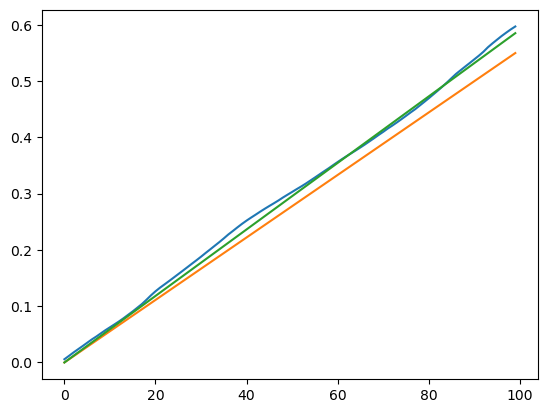

In [37]:
plt.plot(np.cumsum(loss_segments)[:100])
ts = range(len(loss_segments))

plt.plot(ts[:100],ts[:100]*segmentation[0]['a_hat'][0]/segmentation[0]['b_hat'][0])
plt.plot(ts[:100],ts[:100]*segmentation[0]['a_hat'][1]/segmentation[0]['b_hat'][1])

In [12]:
segmentation[2]

{'t0': 327,
 't1': 464,
 'statistic': array([0.01274047, 0.02793646, 0.04086733, 0.05517133, 0.06908534,
        0.08575939, 0.1022255 , 0.1183662 , 0.13096361, 0.14238118,
        0.1549319 , 0.16567281, 0.17864883, 0.191007  , 0.2043073 ,
        0.21887964, 0.23080386, 0.24225862, 0.25404873, 0.26460895,
        0.2747283 , 0.28337073, 0.29246393, 0.30176085, 0.3104294 ,
        0.31894964, 0.3277391 , 0.33593765, 0.34461525, 0.35367453,
        0.36345407, 0.37202808, 0.381261  , 0.38989997, 0.39917776,
        0.4088185 , 0.41849232, 0.42916137, 0.43980125, 0.45006517,
        0.4603012 , 0.46929538, 0.4780627 , 0.488454  , 0.4977131 ,
        0.50826865, 0.5194389 , 0.53019255, 0.5410596 , 0.55281985,
        0.5641138 , 0.5750349 , 0.58491415, 0.5938672 , 0.6032977 ,
        0.61211354, 0.62011456, 0.62851655, 0.63686025, 0.6460627 ,
        0.65563816, 0.6672176 , 0.6777958 , 0.6882952 , 0.7008075 ,
        0.7130691 , 0.72411925, 0.7350585 , 0.74537766, 0.75586414,
        0.7

 12%|█▏        | 20/171 [00:00<00:00, 191.34it/s]

1.335048022141591 75.97498


 47%|████▋     | 80/171 [00:00<00:00, 241.23it/s]

Change Alarm at 95


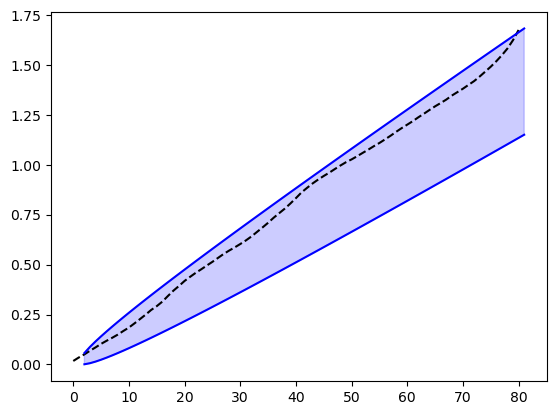

In [162]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,30,split=0.5))
SWDs = []

calibrated = False
t=0
for i , d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device),d[1].squeeze(0).to(device)
   
    THETA = sample_theta_torch(x_ref,1000)
    loss = project_and_calc_dist_torch(x_ref,x_cur,THETA,p=2,device=device).mean(axis=0).detach().cpu().numpy()

    
    
    SWDs.append(loss.mean())

    if not calibrated:
        alpha_hat,beta_hat = mom_estimates(loss)
        print(alpha_hat,beta_hat)
        calibrated = True
        lower_CI = [0]
        upper_CI  = [0]
        cumsum = loss.mean()
        t+=1

    if calibrated:
        l,u = gamma_conf_interval(i,alpha_hat,1/beta_hat,0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ###check change point
        cumsum+=loss.mean()
        if cumsum >= u or cumsum <= l:
            print("Change Alarm at {}".format(i+15))
            break
        


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);

  6%|▌         | 10/171 [00:00<00:00, 195.94it/s]

Warmup complete. Estimated parameters: alpha_hat=1.3129945745152551, beta_hat=76.23937225341797
Change Alarm at 25


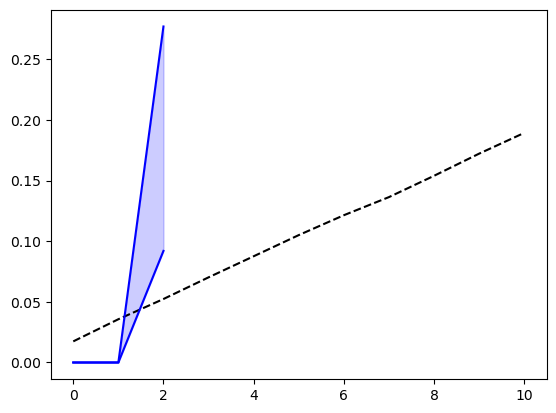

In [118]:
SWDs = []

calibrated = False
warmup = True
warmup_losses = []  # List to store losses during the warmup phase
warmup_steps = 10   # Number of steps for the warmup phase

for i, d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    THETA = sample_theta_torch(x_ref, 1000)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()
    
    SWDs.append(loss.mean())

    if warmup and i < warmup_steps:
        # Collect losses during the warmup phase
        warmup_losses.append(loss)
        lower_CI = [0]
        upper_CI = [0]
        continue  # Skip the rest of the loop until warmup is complete
    
    if warmup and i == warmup_steps:
        # End of the warmup phase: Estimate parameters and start calibration
        warmup = False
        calibrated = True
        alpha_hat, beta_hat = mom_estimates(np.array(warmup_losses))  # Use collected warmup losses
        lower_CI.append(0)
        upper_CI.append(0)
        cumsum = np.mean(warmup_losses)  # Initialize cumulative sum with warmup mean
        print(f"Warmup complete. Estimated parameters: alpha_hat={alpha_hat}, beta_hat={beta_hat}")

    if calibrated:
        l, u = gamma_conf_interval(i , alpha_hat, 1 / beta_hat, 0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ### Check change point
        cumsum += loss.mean()
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at {i + 15}")
            break


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);